In [813]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation, cosine

In [814]:
books = pd.read_csv('BX-CSV-Dump/BX-Books.csv', sep=';', error_bad_lines = False, encoding='latin-1')
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'Publisher', 'Year-Of-Publication'], axis=1, inplace=True)
ratings = pd.read_csv('BX-CSV-Dump/BX-Book-Ratings.csv', sep=';', error_bad_lines = False, encoding='latin-1')
users = pd.read_csv('BX-CSV-Dump/BX-Users.csv', sep=';', error_bad_lines = False, encoding='latin-1')
users.drop(['Location'], axis = 1, inplace=True)

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/Users/jneilcottle/anaconda3/lib/python3.7/site-packages/IPython/core/inte

Clean up data; do we have ratings for books that are not in the book data? Which rating system will we use (implict, explict)? Are there Nans?

In [815]:
def cleanRatings(allratings, books):
    ratings_allbooks = allratings[allratings['ISBN'].isin(books['ISBN'])]
    ratings_implicit = ratings_allbooks[ratings_allbooks["Book-Rating"] == 0]
    ratings_explicit = ratings_allbooks[ratings_allbooks["Book-Rating"] != 0]
    
    ratings_implicit["Book-Rating"] = np.ones(len(ratings_implicit['Book-Rating']))
    
    return ratings_implicit, ratings_explicit

Make the dataset smaller, we don't need users that have rated few books or books with few ratings

Take only the books with more than 50 ratings and only the users who have rated at least 100 books

In [816]:
def reduceRates(rates, userLimit, bookLimit):
    count_users = rates['User-ID'].value_counts()
    count_books= rates['ISBN'].value_counts()
    
    fig, ax = plt.subplots(1,2)
    ax[0].hist(count_users.values, bins = int(np.max(count_users.values)/100))
    ax[0].set_yscale('log')
    ax[0].set_xlim(0, 3000)
    ax[0].plot([userLimit, userLimit],[1, 60000], linestyle = 'dashed', color = 'red')
    ax[0].set_title('Ratings by Users')
    ax[0].set_xlabel('Ratings')
    ax[0].set_ylabel('Number of Users')

    ax[1].hist(count_books.values, bins = int(np.max(count_books.values)/50))
    ax[1].set_yscale('log')
    ax[1].set_xlim(0, 1000)
    ax[1].plot([bookLimit, bookLimit],[1, 60000], linestyle = 'dashed', color = 'red')
    ax[1].set_title('Ratings by Books')
    ax[1].set_xlabel('Ratings')
    ax[1].set_ylabel('Number of Books')
    
    rates = rates[rates['User-ID'].isin(count_users[count_users >=userLimit].index)]
    rates = rates[rates['ISBN'].isin(count_books[count_books >=bookLimit].index)]
    
    return rates

In [817]:
def makeMatrix(rates):
    rates = rates.pivot(index='User-ID', columns='ISBN', values='Book-Rating')
    rates = rates.where(pd.notnull(rates), 0)
    print('Matrix shape {}'.format(rates.shape))
    return rates

In [818]:
def findBooks(user_inds):
    books = np.zeros(ratings_matrix.iloc[0, :].values.shape)
    for ids in user_inds:
        user_vec = ratings_matrix.iloc[ids, :].values
        books = books + user_vec
    
    books = pd.Series(books)
    books = books.sort_values(ascending=False)
    top100 = books[:100]
    bookIds = []
    bookValues = []
    for i, ind in enumerate(top100.index):
        bookIds.append(ratings_matrix.columns[ind])
        bookValues.append(top100.values[i])
    return bookIds, bookValues

In [828]:
#find the mean rating for a given user, only looking at book which they've rated
def calcMean(user_loc):
    user_ratings = ratings_matrix.iloc[user_loc, :]
    #select only where rating != 0
    user_ratings = user_ratings[user_ratings != 0]
    
    mean = np.sum(user_ratings)/len(user_ratings)
    return mean

def findTitle(isbn):
    p = books.set_index('ISBN').index.get_loc(isbn)
    return books['Book-Title'][p]

In [829]:
#predict rating for a specific item/user
def predict_rating_explicit(user_loc, item_loc, sim_user_ind, sims):
    mean_rating_user = calcMean(user_loc)
    sim_sum = np.sum(sims)
    rate_sum = 0
    #loop through similar users
    for i, sim_user in enumerate(sim_user_ind):        
        product = ratings_matrix.iloc[sim_user, item_loc]*sims[i]
        rate_sum=new_sum+product

    prediction = (rate_sum/sim_sum)
    return prediction

#predict rating for a specific item/user
def predict_rating_implicit(user_loc, item_loc, sim_user_ind, sims, bookvalue):
    mean_rating_user = calcMean(user_loc)
    sim_sum = np.sum(sims)
    rate_sum = 0
    #loop through similar users
    for i, sim_user in enumerate(sim_user_ind):        
        product= ratings_matrix.iloc[sim_user, item_loc]*sims[i]  #weight rating by similarity
        rate_sum=rate_sum+product

    prediction = (rate_sum/sim_sum)
    return prediction

In [830]:
#find the most likely to be read over all books
def recommendbook(user_id, ratings_matrix):
    knn_model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
    knn_model.fit(ratings_matrix)
    
    user_loc = ratings_matrix.index.get_loc(user_id)
    user_vec = ratings_matrix.iloc[user_loc, :].values.reshape(1, -1)
    
    #find similar users
    dist, indices = knn_model.kneighbors(user_vec, n_neighbors= 7)
    
    #ignore the first item, it is the original user
    sims = 1-dist.flatten()[1:] #most similar is closest to 1
    sim_user_ind = indices.flatten()[1:]
    print(sims)
    
    #list books similar users have read
    simUserBooks, bookValues = findBooks(sim_user_ind)
    
    predictions = []
    for i, book in enumerate(simUserBooks):
        item_loc = ratings_matrix.columns.get_loc(book)
        if (ratings_matrix.iloc[user_loc, item_loc] == 0):
            #predictions.append((predict_rating_explicit(user_loc, item_loc, sim_user_ind, sims), book))
            predictions.append((predict_rating_implicit(user_loc, item_loc, sim_user_ind, sims, bookValues[i]), book))
        else:
            predictions.append((-1, book)) #already read
    
    predictions = pd.Series(predictions)
    predictions = predictions.sort_values(ascending=False)
    recommend = predictions[:10]

    for i, (rate, book) in enumerate(recommend):
        bookTitle = findTitle(book)
        print("{} {} (expected rating {:0.2f})".format(i+1, bookTitle, rate))

## Time to put the recommender to use!

In [831]:
imp, exp = cleanRatings(ratings, books)

/Users/jneilcottle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Populatarity based recommendations; what books have been read the most? 

In [832]:
ratings_pop = pd.DataFrame(imp.groupby(['ISBN'])['Book-Rating'].sum())
top10 = ratings_pop.sort_values('Book-Rating', ascending=False).head(10)
top10.merge(books, left_index=True, right_on = 'ISBN')

,Book-Rating,ISBN,Book-Title,Book-Author
26,1921.0,0971880107,Wild Animus,Rich Shapero
408,588.0,0316666343,The Lovely Bones: A Novel,Alice Sebold
1105,412.0,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells
748,396.0,0385504209,The Da Vinci Code,Dan Brown
305,366.0,044023722X,A Painted House,John Grisham
1922,358.0,067976402X,Snow Falling on Cedars,David Guterson
2445,349.0,0440214041,The Pelican Brief,John Grisham
522,340.0,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant
67,325.0,0804106304,The Joy Luck Club,Amy Tan
4430,323.0,0375727345,House of Sand and Fog,Andre Dubus III


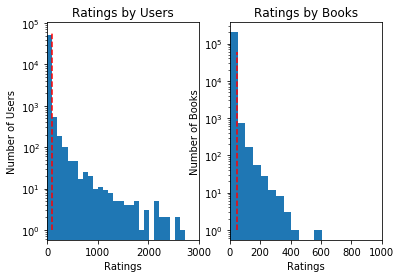

In [833]:
imp_small = reduceRates(imp, 100, 50)

In [834]:
ratings_matrix = makeMatrix(imp_small)

Matrix shape (1071, 1073)


In [835]:
recommendbook(11676, ratings_matrix)

[0.35877996 0.33479867 0.33110009 0.30135791 0.28309318 0.28091998]
1 Where the Heart Is (Oprah's Book Club (Paperback)) (expected rating 1.00)
2 The Notebook (expected rating 1.00)
3 The Runaway Jury (expected rating 1.00)
4 The Perfect Storm : A True Story of Men Against the Sea (expected rating 1.00)
5 The Summons (expected rating 0.85)
6 The Testament (expected rating 0.85)
7 Hannibal (expected rating 0.85)
8 Fine Things (expected rating 0.85)
9 The Last Precinct (expected rating 0.85)
10 Move to Strike (expected rating 0.85)


In [836]:
def printUserBooks(user_id):
    user_loc = ratings_matrix.index.get_loc(user_id)
    user_vec = ratings_matrix.iloc[user_loc, :].values.reshape(1, -1).flatten()
    print(user_vec)
    
    for i, rate in enumerate(user_vec):
        if rate == 1:
            isbn = ratings_matrix.columns[i]
            print(findTitle(isbn))

In [837]:
printUserBooks(11676)

[0. 0. 0. ... 0. 0. 0.]
She Went All the Way (Avon Light Contemporary Romances)
The Boy Next Door
Divine Secrets of the Ya-Ya Sisterhood : A Novel
Stupid White Men ...and Other Sorry Excuses for the State of the Nation!
The Bean Trees
Animal Dreams
Divine Secrets of the Ya-Ya Sisterhood: A Novel
The Poisonwood Bible: A Novel
Daughter of Fortune
Bel Canto: A Novel
Prodigal Summer: A Novel
Little Altars Everywhere: A Novel
The God of Small Things
Moment of Truth
A Theory of Relativity
Mistaken Identity
The Saving Graces: A Novel
The Bean Trees
The Wailing Wind
Memoirs of a Geisha Uk
Lake Wobegon days
Of Mice and Men (Penguin Great Books of the 20th Century)
Songs in Ordinary Time (Oprah's Book Club (Paperback))
Bridget Jones's Diary
Year of Wonders
The Secret Life of Bees
The Eyre Affair: A Novel
Where or When  : A Novel
The Crimson Petal and the White
Mrs Dalloway


KeyboardInterrupt: 

In [769]:
#for a given user,
#remove 10 books, 
#then try to recommend books for that user
#then check to see if any/all of those books where ones that were removed
